In [101]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context = 'talk', font_scale = 1.05)

# Set a hashed-line function:
def abline(slope, intercept, style, color):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, style, color = color)

In [102]:
# Load Data
data = pd.read_csv('processed_data_I.csv')
data.drop(['Unnamed: 0', 'Country Code', 'Year'], axis = 1, inplace = True)
country_list = pd.read_excel('constraints.xlsx', sheet_name = 'country-code')

# Add country names
data = pd.merge(left = country_list,
                right = data,
                on = 'iso_a3')

# Update numerical columns as percentages
data['big_mac_index'] = data['big_mac_index']*100
data['labor comp per capita'] = data['labor comp per capita']*100 
data['big_mac_affordability'] = (data['GDP per capita'] / data['dollar_price']) / 365

**Big Mac Valuation**

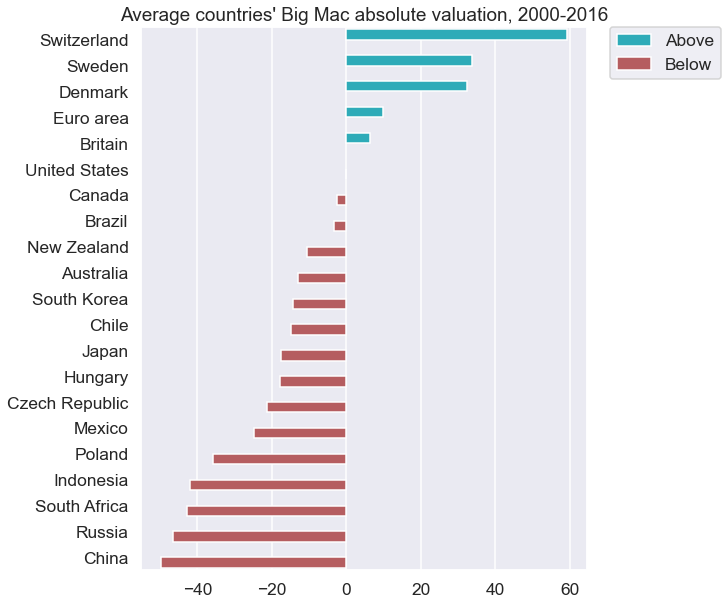

In [135]:
avg_across_years = data.groupby(by = ['iso_a3','name'], as_index = False).agg({'big_mac_index': 'mean',
                                                                               'labor comp per capita': 'mean',
                                                                               'Curr Acc Balance': 'mean',
                                                                               'GGB': 'mean',
                                                                               'big_mac_affordability': 'mean'})
avg_across_years['over'] = avg_across_years['big_mac_index'].apply(lambda x: 'Above' if x > 0 else 'Below')


# Plot Big Mac Average Valudation for all countries
fig = plt.figure(figsize = (8, 10))
sns.barplot(data = avg_across_years.sort_values(by = 'big_mac_index', ascending = False), 
            x = 'big_mac_index', 
            y = 'name',
            hue = 'over',
            palette = dict({'Above': 'tab:cyan', 'Below': 'r'}))

plt.ylabel('')
plt.xlabel('')
plt.title("Average countries' Big Mac absolute valuation, 2000-2016")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

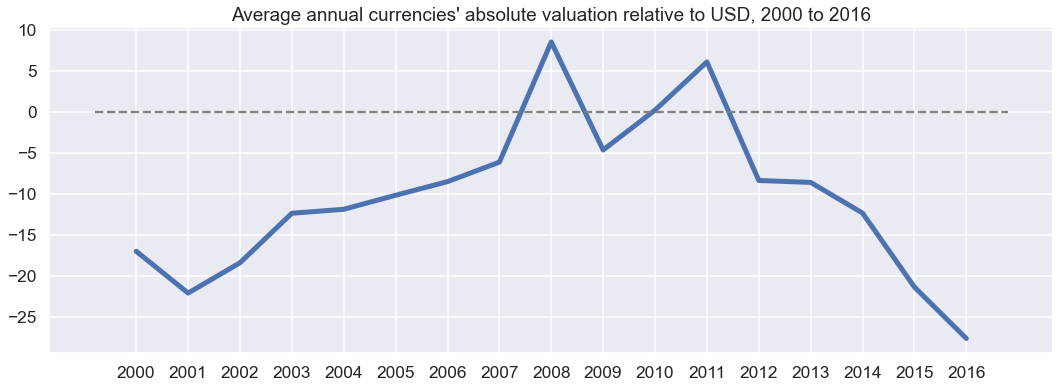

In [113]:
avg_across_country = data.groupby(by = ['year'], as_index = False).agg({'big_mac_index': 'mean',
                                                                        'labor comp per capita': 'mean',
                                                                        'Curr Acc Balance': 'mean',
                                                                        'GGB': 'mean',
                                                                        'big_mac_affordability': 'mean'})

# Plot Big Mac Average Valuation across years
fig = plt.figure(figsize = (18, 6))
g = sns.lineplot(data = avg_across_country.sort_values(by = 'year', ascending = True), 
                 x = 'year', 
                 y = 'big_mac_index',
                 linewidth = 5)
abline(0, 0, '--', 'grey')

g.set(title = "Average annual currencies' absolute valuation relative to USD, 2000 to 2016", 
      xlabel = '', ylabel = '', 
      xticks = avg_across_country['year'].tolist())
#plt.xticks(rotation=90)

plt.show()

**Big mac Affordability**

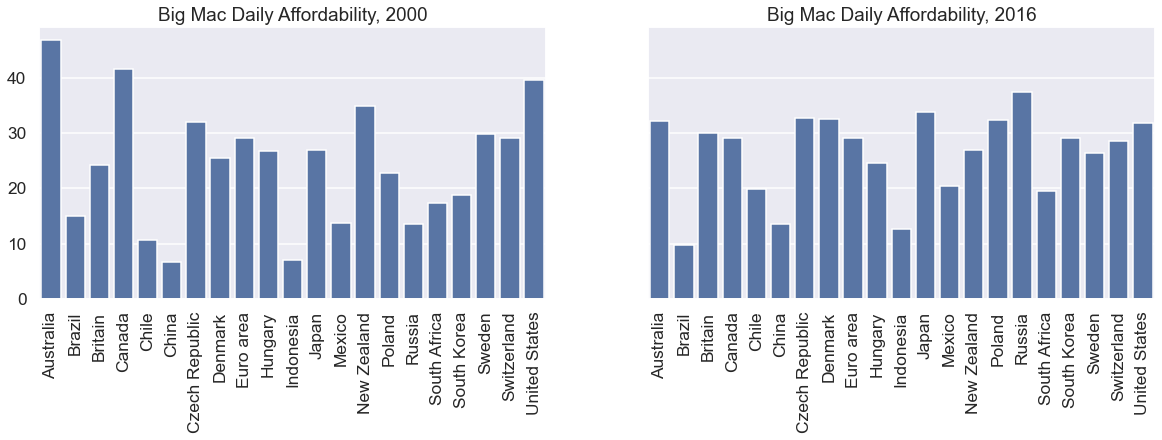

In [147]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize = (20, 5))

plt.sca(ax[0])
sns.barplot(data = data.loc[data['year'] == 2000], 
            y = 'big_mac_affordability', 
            x = 'name',
            color = 'b').set(title = 'Big Mac Daily Affordability, 2000', xlabel = '', ylabel = '')
plt.xticks(rotation=90)

plt.sca(ax[1])
sns.barplot(data = data.loc[data['year'] == 2016], 
            y = 'big_mac_affordability', 
            x = 'name',
            color = 'b').set(title = 'Big Mac Daily Affordability, 2016', xlabel = '', ylabel = '')
plt.xticks(rotation=90)

plt.show()

**Big Mac Valuation - relationship with Determinants**

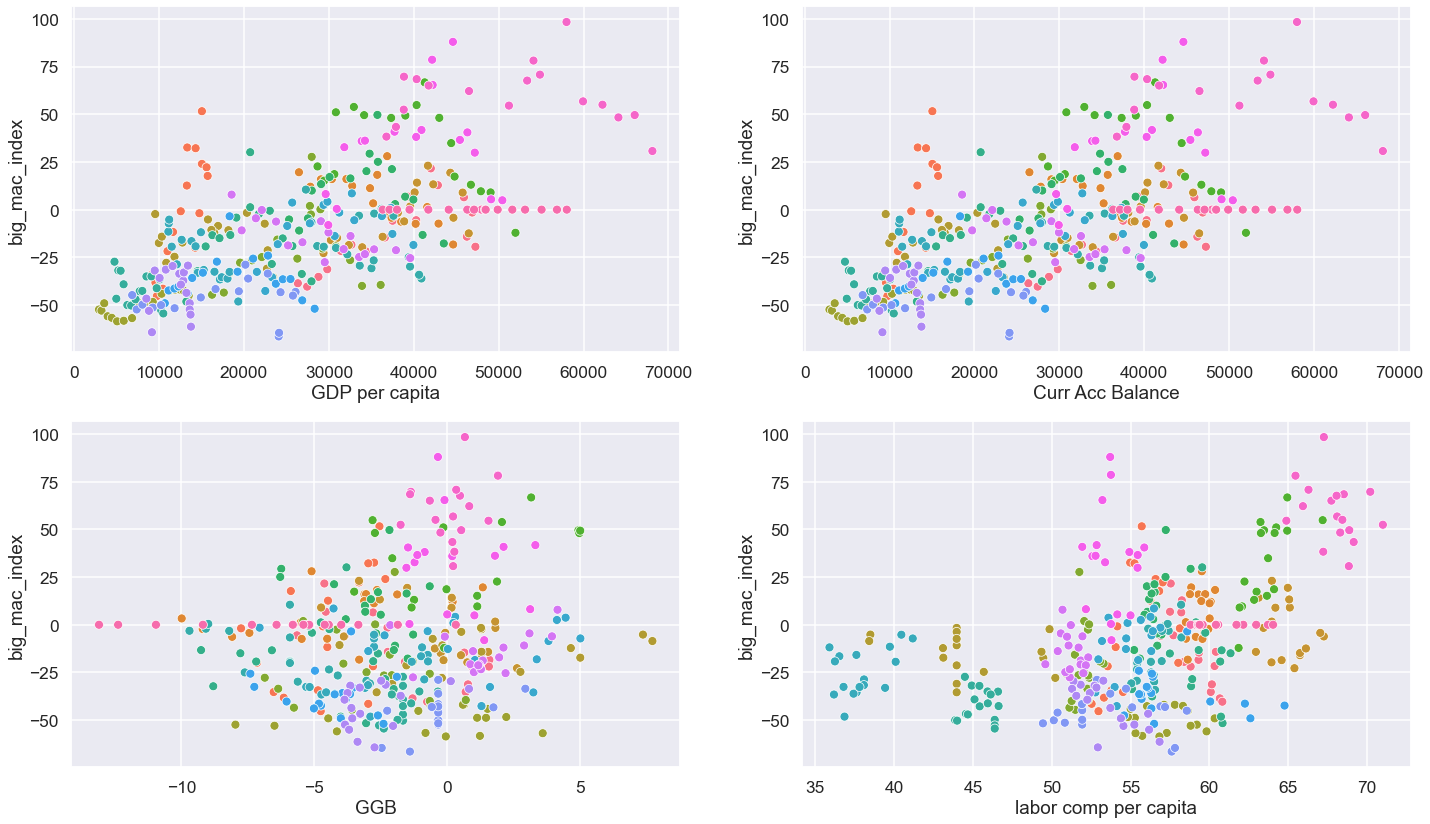

In [159]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (24, 14))

for idx, col in enumerate(['GDP per capita', 'Curr Acc Balance', 'GGB', 'labor comp per capita']):
    plt.sca(ax[idx//2, idx%2])
    sns.scatterplot(data = data, x = col, y = 'big_mac_index', hue = 'name')
    plt.legend([],[], frameon=False)

**Descriptive Statistics of variables**

In [149]:
data.describe()

,year,local_price,dollar_ex,dollar_price,big_mac_index,GDP per capita,Curr Acc Balance,GGB,labor comp per capita,big_mac_affordability
count,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000
mean,2008.000000,1267.876218,574.423229,3.206109,-10.245314,27097.617453,27097.617453,-1.974667,55.449663,23.127917
std,4.905855,4509.542275,2133.368660,1.328796,31.391388,13928.559769,13928.559769,3.212204,6.927827,8.723235
min,2000.000000,1.880000,0.501040,0.889908,-66.471723,2920.560791,2920.560791,-13.099931,35.892659,6.686592
25%,2004.000000,4.900000,1.317700,2.262929,-34.959293,14297.221390,14297.221390,-3.897100,52.159649,16.447616
50%,2008.000000,17.950000,6.720000,2.963807,-13.822278,27533.737340,27533.737340,-1.953151,56.169033,23.289831
75%,2012.000000,78.000000,34.388250,4.065000,4.916213,37499.525130,37499.525130,0.202036,59.515077,27.593920
max,2016.000000,30750.000000,13530.000000,8.063016,98.352166,68105.154980,68105.154980,7.739158,70.999104,49.617223
